<a href="https://colab.research.google.com/github/fauk74/Machine-Learning/blob/main/tensorflow_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi


Sat Sep 11 02:33:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#get the data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()


--2021-09-11 02:33:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   158MB/s    in 1.0s    

2021-09-11 02:33:29 (158 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 10 director

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## create data loaders
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
EPOCHS=5

train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"
train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("training images:)")
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")
print("Testing images:")
test_data=test_datagen.flow_from_directory(train_dir,
                                           target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")




training images:)
Found 750 images belonging to 10 classes.
Testing images:
Found 750 images belonging to 10 classes.


# Callbacks


In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir= dir_name + "/"+ experiment_name +"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to {log_dir}")
  return tensorboard_callback



resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
mobile_net_url="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
def create_model (model_url, num_classes=10):

  feature_extractor_layer=hub.KerasLayer(model_url,trainable=False, input_shape=IMAGE_SHAPE+(3,))
  model=tf.keras.Sequential([feature_extractor_layer,
                             layers.Dense(num_classes, activation="softmax", name="output_layer")])
  return model


In [ ]:
resnet_model=create_model(resnet_url,
                          num_classes=train_data_10_percent.num_classes)

In [ ]:
train_data_10_percent.num_classes

10

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
#Compile a resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
history_res_net=resnet_model.fit(train_data_10_percent, 
                      epochs=5, 
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                            experiment_name="resnet50V2")]
)


Saving Tensorboard log files to tensorflow_hub/resnet50V2/20210911-023451
Epoch 1/5
24/24 [==============================] - 45s 571ms/step - loss: 1.8158 - accuracy: 0.3787 - val_loss: 1.0578 - val_accuracy: 0.6693
Epoch 2/5
24/24 [==============================] - 11s 450ms/step - loss: 0.8872 - accuracy: 0.7160 - val_loss: 0.6692 - val_accuracy: 0.8080
Epoch 3/5
24/24 [==============================] - 11s 449ms/step - loss: 0.6154 - accuracy: 0.8200 - val_loss: 0.5004 - val_accuracy: 0.8667
Epoch 4/5
24/24 [==============================] - 11s 447ms/step - loss: 0.4816 - accuracy: 0.8733 - val_loss: 0.3951 - val_accuracy: 0.9013
Epoch 5/5
24/24 [==============================] - 11s 450ms/step - loss: 0.3828 - accuracy: 0.9093 - val_loss: 0.3226 - val_accuracy: 0.9360


In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]
  accuracy= history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]
  epochs=range(len(history.history["loss"]))

#Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

#Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

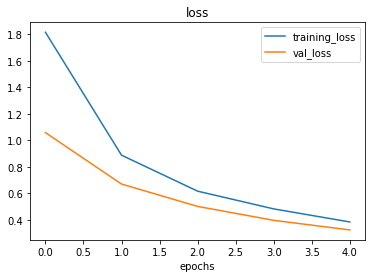

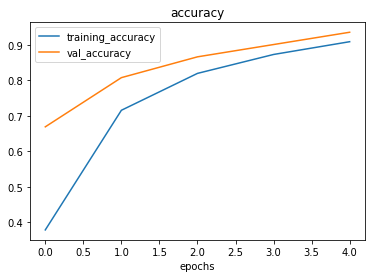

In [ ]:
plot_loss_curves(history_res_net)

## EFFICIENT NET

In [ ]:

efficientnet_model=create_model(efficientnet_url,
                          num_classes=train_data_10_percent.num_classes)

In [ ]:
#Compile a resnet model
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
history_efficient_net=efficientnet_model.fit(train_data_10_percent, 
                      epochs=5, 
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                            experiment_name="efficientnetb0")])

Saving Tensorboard log files to tensorflow_hub/efficientnetb0/20210911-023646
Epoch 1/5
24/24 [==============================] - 25s 586ms/step - loss: 1.8087 - accuracy: 0.4680 - val_loss: 1.2555 - val_accuracy: 0.7573
Epoch 2/5
24/24 [==============================] - 9s 399ms/step - loss: 1.0382 - accuracy: 0.7893 - val_loss: 0.8226 - val_accuracy: 0.8267
Epoch 3/5
24/24 [==============================] - 9s 395ms/step - loss: 0.7426 - accuracy: 0.8400 - val_loss: 0.6351 - val_accuracy: 0.8693
Epoch 4/5
24/24 [==============================] - 9s 398ms/step - loss: 0.5954 - accuracy: 0.8693 - val_loss: 0.5276 - val_accuracy: 0.8867
Epoch 5/5
24/24 [==============================] - 9s 400ms/step - loss: 0.5061 - accuracy: 0.8867 - val_loss: 0.4523 - val_accuracy: 0.9093


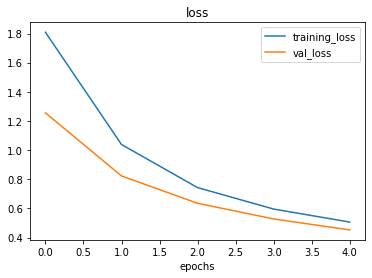

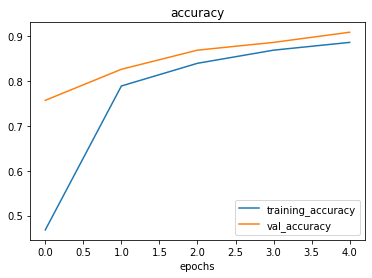

In [ ]:
plot_loss_curves(history_efficient_net)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
len(efficientnet_model.layers[0].weights)

309

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNet vs Resnet" \
    --description "Comparing two different TF Hub feature extraction model architectures"

2021-09-11 02:52:34.528037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-11 02:52:34.555339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-11 02:52:34.555843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac

In [ ]:
!tensorboard dev list

## Mobile Net

In [ ]:

mobile_net_model=create_model(mobile_net_url,
                          num_classes=train_data_10_percent.num_classes)
#Compile a resnet model
mobile_net_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])
mobile_net=efficientnet_model.fit(train_data_10_percent, 
                      epochs=5, 
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                            experiment_name="mobile_net_v5")])


Saving Tensorboard log files to tensorflow_hub/mobile_net_v5/20210911-023826
Epoch 1/5
24/24 [==============================] - 12s 491ms/step - loss: 0.4368 - accuracy: 0.9080 - val_loss: 0.3953 - val_accuracy: 0.9160
Epoch 2/5
24/24 [==============================] - 9s 399ms/step - loss: 0.3855 - accuracy: 0.9227 - val_loss: 0.3512 - val_accuracy: 0.9333
Epoch 3/5
24/24 [==============================] - 9s 398ms/step - loss: 0.3440 - accuracy: 0.9347 - val_loss: 0.3142 - val_accuracy: 0.9427
Epoch 4/5
24/24 [==============================] - 9s 398ms/step - loss: 0.3077 - accuracy: 0.9427 - val_loss: 0.2833 - val_accuracy: 0.9533
Epoch 5/5
24/24 [==============================] - 9s 398ms/step - loss: 0.2796 - accuracy: 0.9480 - val_loss: 0.2558 - val_accuracy: 0.9627


# Test Data augmentation 

In [ ]:
# https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 

def view_random_image(target_dir, target_class):
  target_folder=target_dir+target_class
  random_image=random.sample(os.listdir(target_folder),1)
  print(random_image)

  img=mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape : {img.shape}")
  return img

['2110698.jpg']
Image shape : (512, 512, 3)


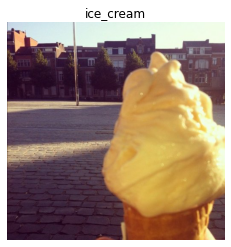

In [ ]:
img=view_random_image(target_dir="/content/10_food_classes_10_percent/test/", target_class="ice_cream")

In [ ]:
# Add the image to a batch
img = tf.expand_dims(img, 0)

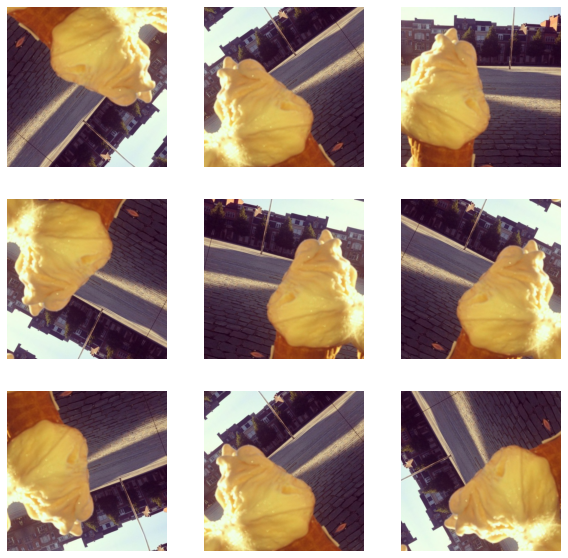

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(img)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")